In [1]:
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

In [2]:
df = pd.read_csv('/content/yelp_labelled.txt', names=['sentence', 'label'], sep='\t')
df.tail()

,sentence,label
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0
999,"Then, as if I hadn't wasted enough of my life ...",0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [4]:
df['sentence'] = df['sentence'].str.lower()
df.tail()

,sentence,label
995,i think food should have flavor and texture an...,0
996,appetite instantly gone.,0
997,overall i was not impressed and would not go b...,0
998,"the whole experience was underwhelming, and i ...",0
999,"then, as if i hadn't wasted enough of my life ...",0


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
stop_word = set(stopwords.words('english'))
df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))
df.tail()

,sentence,label
995,think food flavor texture lacking.,0
996,appetite instantly gone.,0
997,overall impressed would go back.,0
998,"whole experience underwhelming, think we'll go...",0
999,"then, wasted enough life there, poured salt wo...",0


In [7]:
sentence = df['sentence'].values
label = df['label'].values

In [8]:
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, label, test_size=0.2, shuffle=False)

print('Training dataset:\n', sentence_train.shape, label_train.shape)
print('\nTest dataset:\n', sentence_test.shape, label_test.shape)

Training dataset:
 (800,) (800,)

Test dataset:
 (200,) (200,)


In [9]:
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ' # Untuk menghilangkan symbols

tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>", filters=filt)

tokenizer.fit_on_texts(sentence_train)

In [10]:
word_index = tokenizer.word_index
print(len(word_index))

1732


In [11]:
with open('word_index.json', 'w') as fp:
    json.dump(word_index, fp)

In [12]:
train_sekuens = tokenizer.texts_to_sequences(sentence_train)
test_sekuens = tokenizer.texts_to_sequences(sentence_test)


train_padded = pad_sequences(train_sekuens, 
                             maxlen=20,
                             padding='post',
                             truncating='post')
test_padded = pad_sequences(test_sekuens,
                            maxlen=20,
                            padding='post',
                            truncating='post')

In [13]:
train_padded.shape

(800, 20)

In [14]:
test_padded.shape

(200, 20)

In [15]:
model = tf.keras.Sequential([
    Embedding(2000, 20, input_length=20),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            40000     
                                                                 
 global_average_pooling1d (G  (None, 20)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 43,457
Trainable params: 43,457
Non-trainable params: 0
____________________________________________________

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
num_epochs = 30
history = model.fit(train_padded, label_train, 
                    epochs=num_epochs, 
                    validation_data=(test_padded, label_test),
                    verbose=1)

Epoch 1/30
25/25 [==============================] - 1s 19ms/step - loss: 0.6889 - accuracy: 0.5650 - val_loss: 0.7342 - val_accuracy: 0.2400
Epoch 2/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.5650 - val_loss: 0.7748 - val_accuracy: 0.2400
Epoch 3/30
25/25 [==============================] - 0s 5ms/step - loss: 0.6744 - accuracy: 0.5650 - val_loss: 0.7699 - val_accuracy: 0.2400
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6506 - accuracy: 0.5850 - val_loss: 0.7567 - val_accuracy: 0.2550
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5843 - accuracy: 0.7275 - val_loss: 0.8053 - val_accuracy: 0.3000
Epoch 6/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4586 - accuracy: 0.8413 - val_loss: 0.6633 - val_accuracy: 0.5750
Epoch 7/30
25/25 [==============================] - 0s 7ms/step - loss: 0.3096 - accuracy: 0.9375 - val_loss: 0.6377 - val_accuracy: 0.6550
Epoch 8/30
25/25 [=

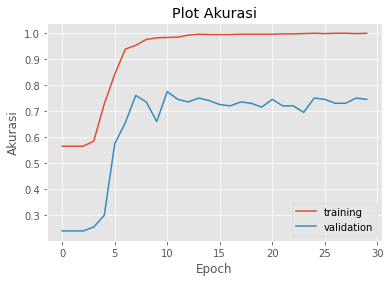

In [18]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="training")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="validation")
plt.title("Plot Akurasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()
plt.savefig('images/plot_acc.png')
plt.show()

In [19]:
model.save("model.h5")

In [20]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model